In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
clinical_path = 'data/clean/clinical/data_with_derived_variables.csv'
zz_log_path = 'data/clean/protein/zz_log_10.csv'

I am using double z-score transformed log10 abundance levels here. This has an advantage of reducing the effect of technical variation (i.e. more material taken from a patient) and in the second step - centering the protein levels around the mean (so that we can separate easily into two groups i.e. low and high),

In [4]:
clinical = read_csv(clinical_path, index_col=0)
protein_levels = read_csv(zz_log_path, index_col=0)

## Survival analysis

Also see the survival analysis on clinical variables only: [Clinical_survival.ipynb](../Clinical_survival.ipynb).

How feasible is survival analysis for protein data?

In [5]:
sum(~clinical['survival'].isnull())

22

Feasible (15/22 patients ho have deceased have protein data), but any split (esp. other than in half) will have little power, though the censored data may be informative too.

Important piece: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3071962/

In [6]:
pd.options.mode.chained_assignment = None
c = clinical[['censored_survival', 'Death', 'Sex', 'HIVResult', 'Meningitis', 'Tuberculosis']]

In [7]:
data = concat([protein_levels.T, c], axis=1)

In [8]:
%%R
library("survminer")
library("survival")
source('helpers/survival.R')

In [9]:
data['Albumin_high_low'] = (data['Albumin'] > 0).map({True: 'High', False: 'Low'})

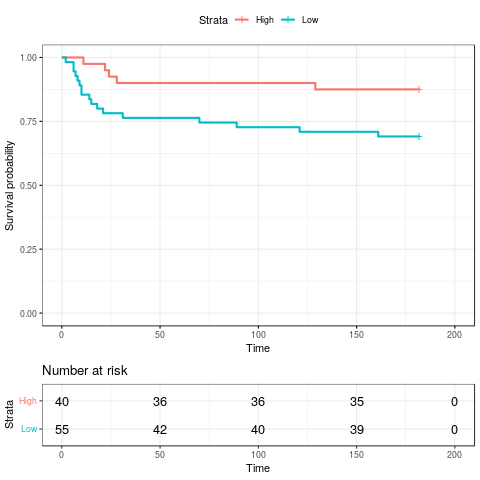

In [10]:
%%R -i data
fit <- survfit(Surv(data$censored_survival, data$Death) ~ Albumin_high_low, data=data)
strata = strip_strata_prefix(fit)

ggsurvplot(
    fit, data=data,
    legend.labs=strata,
    risk.table=T, ggtheme=theme_bw()
)